# Invasive Ductal Carcinoma Classification and Targeting Model in Breast Histopathology
# Ishaan Jain, 200968045

## Package settings

In [1]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import matplotlib.image as plt_img
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score

from os import listdir
import os

## Loading and storing the datasets
The whole image file has 162 whole mount slide images taken at 40x.  
There are 277,524 patch images with a size of 50 x 50 extracted from the entire image.  
Of these, 198,738 are IDC negative and 78,786 are IDC positive.  
The patient ID, class (0: non-IDC, 1: IDC), location path of the image file, x coordinate, y coordinate are collected from the patch image file and stored.  
(※ Due to the large capacity to use all the data, only a portion was used.)  

See the original site below for more details.  
https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images

In [2]:
def load_data(max_num = None, save = False, shuffle = True):
    base = '/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5'  # Root path including all files
    files = listdir(base)

    if max_num is None:
        max_num = len(files)
    if shuffle:
        files = np.random.choice(files, size = max_num)
        
    informations = []
    for patient_id in files[:max_num]:
        patient_path = base + '/' + patient_id
        column = ['ID', 'cancer', 'image_path', 'x_coor', 'y_coor']

        for target in range(2):
            class_path = patient_path + '/' + str(target)
            for image in listdir(class_path):
                info = []
                info.append(patient_id)                    # Patient ID
                info.append(target)                        # Class (0: non-IDC, 1: IDC)
                info.append(class_path + '/' + str(image)) # Image path

                # Decompose Image name to extract X and Y coordinates
                # 8863_idx5_x51_y1251_class0   -> '8863', 'id', '5', '', '51', '', '1251', 'class0'
                img = re.split('[x y _]', image)
                info.append(img[4]) # X coordinate
                info.append(img[6]) # Y coordinate
                informations.append(info)

    df = pd.DataFrame(np.array(informations), columns = column)
    df[['ID', 'cancer', 'x_coor', 'y_coor']] = df[['ID', 'cancer', 'x_coor', 'y_coor']].astype('int32')
    
    if save:
        df.to_csv('./data.csv')
    return df

data = load_data(max_num = 40)
print(data)

         ID  cancer                                         image_path  \
0      9322       0  /kaggle/input/breast-histopathology-images/IDC...   
1      9322       0  /kaggle/input/breast-histopathology-images/IDC...   
2      9322       0  /kaggle/input/breast-histopathology-images/IDC...   
3      9322       0  /kaggle/input/breast-histopathology-images/IDC...   
4      9322       0  /kaggle/input/breast-histopathology-images/IDC...   
...     ...     ...                                                ...   
40207  9255       1  /kaggle/input/breast-histopathology-images/IDC...   
40208  9255       1  /kaggle/input/breast-histopathology-images/IDC...   
40209  9255       1  /kaggle/input/breast-histopathology-images/IDC...   
40210  9255       1  /kaggle/input/breast-histopathology-images/IDC...   
40211  9255       1  /kaggle/input/breast-histopathology-images/IDC...   

       x_coor  y_coor  
0        2901    1051  
1        1151    1151  
2         151    1251  
3        1401  

# Exploratory analysis:

## Comparing non-IDC vs IDC patches
I want to observe the characteristics of the IDC patch by comparing the images of the non-IDC patch and the IDC patch.

In [3]:
def image_plot(df, row, col, idx, label):
    fig, axes = plt.subplots(row, col, figsize = (col * 4, row * 4))
    fig.suptitle(label + ' patch Images', fontsize = 20)

    for i in range(row):
        for j in range(col):
            image = plt_img.imread(df.loc[idx[i*col + j], 'image_path'])
            axes[i][j].imshow(image)
            axes[i][j].grid(False)

def visualization(df, row, col, shuffle = True):
    postive = []
    negative = []
    if shuffle:
        positive = np.random.choice(df[df['cancer'] == 1].index.values, size = row * col, replace = False)
        negative = np.random.choice(df[df['cancer'] == 0].index.values, size = row * col, replace = False)

    else:
        postive = df[df['cancer'] == 1].index.values[:row * col]
        negative = df[df['cancer'] == 0].index.values[:row * col]

    image_plot(df, row, col, positive, 'IDC')
    image_plot(df, row, col, negative, 'non-IDC')

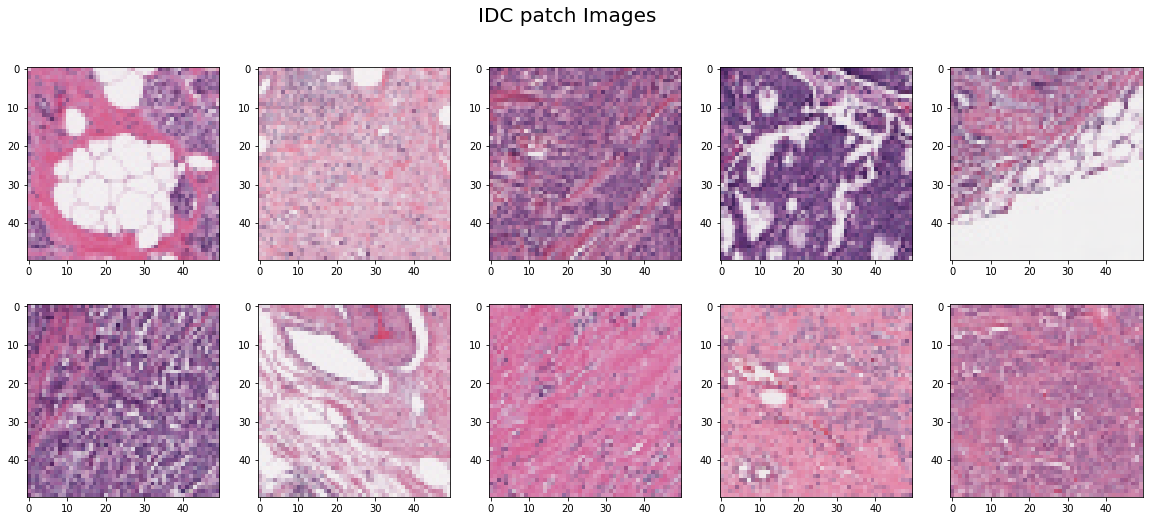

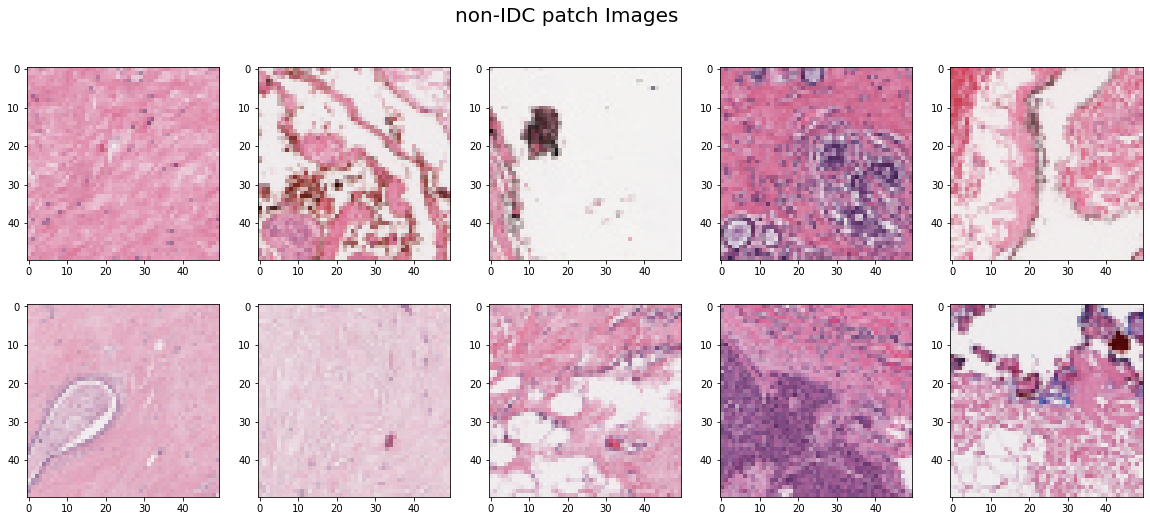

In [4]:
visualization(data, 2, 5)

**IDC patch images generally have a darker color than non-IDC patch images.**  
However, there are dark purple parts in the non-IDC patch images.  
These are expected to be a type of cancer other than IDC. These images can be a factor that lowers the accuracy of the prediction.

## Visualising the IDC positions in each whole slice image
It is expressed as a dot map, and each point means one patch image.  
Based on the x and y coordinates of each patch image, the approximate location of the IDC can be quickly checked without actual image data.  
<span style="color: red">Red dots</span> correspond to <span style="color: red">IDC patches</span>, and <span style="color: blue">blue dots</span> correspond to <span style="color: blue">non-IDC patches</span>.

In [5]:
def simple_whole_tissue(df, row, col, shuffle = True):
    patient_ids = df['ID'].unique() 
    samples = []
    if shuffle:
        samples = np.random.choice(patient_ids, size = row * col, replace = False)
    else:
        samples = patient_ids[:row * col]

    target = 'cancer'

    # Plotting approximate whole slide image shape and IDC location with dots
    fig, axes = plt.subplots(row, col, figsize = (col*10, row *8))
    axes = axes.flatten()
    
    for i in range(row):
        for j in range(col):
            sns.scatterplot(data = df[df['ID'] == samples[i*col + j]], x = 'x_coor', y = 'y_coor', c = df[df['ID'] == samples[i*col + j]][target], cmap = 'coolwarm', s = 20, ax = axes[i*col + j])
            axes[i*col + j].set_title("Patient ID " + str(samples[i*col + j]), fontsize = 20)
            axes[i*col + j].set_xlabel("X coordinate", fontsize = 15)
            axes[i*col + j].set_ylabel("Y coordinate", fontsize = 15)

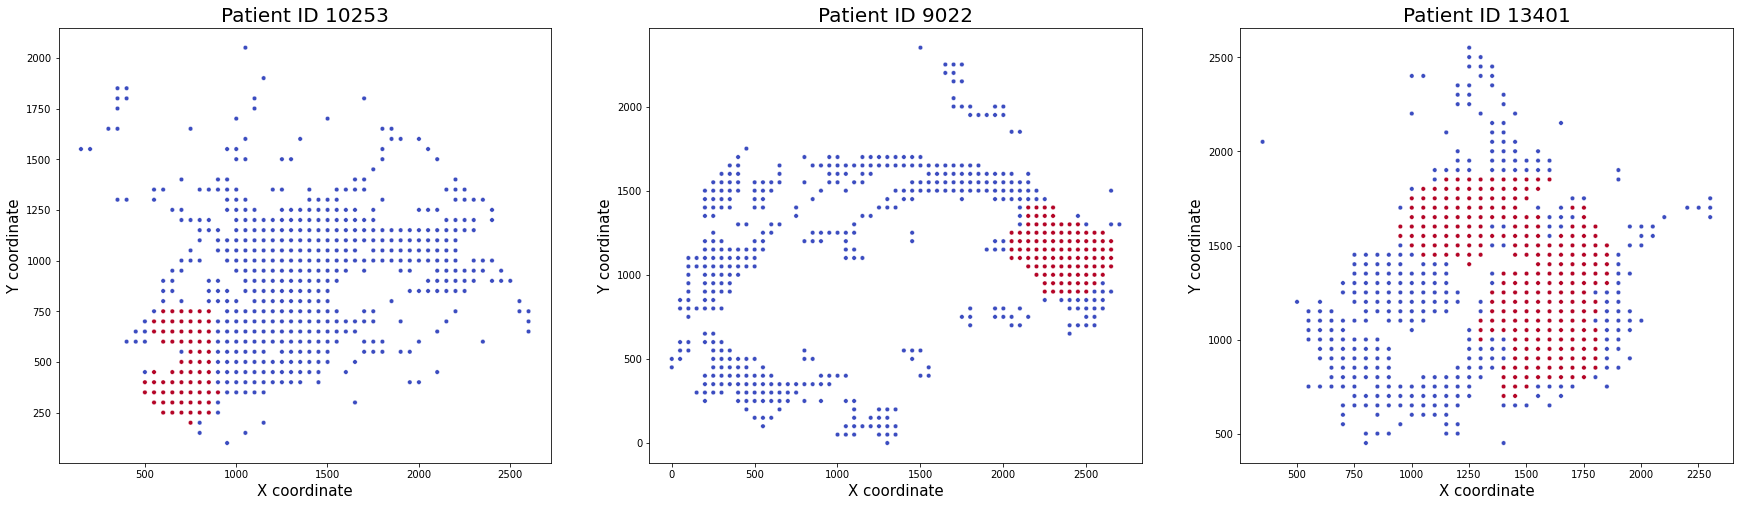

In [6]:
simple_whole_tissue(data, 1, 3)

The position corresponding to the IDC in the Whole slide image can be easily identified.  
It can be observed that the IDC parts are **clustered** together.   
That is, the location information of each patch is also required for IDC classification and prediction.

## Visualising the whole slice images

<span style="color: red">Red parts</span> correspond to <span style="color: red">IDC patches</span>, and <span style="color: blue">blue parts</span> correspond to <span style="color: blue">non-IDC patches</span>.  

For the whole slide image, patch images were loaded from data corresponding to a specific patient's id, and then combined based on the x and y coordinates corresponding to each patch image.  
IDC and non-IDC filters are based on the IDC information of each patch (corresponding to the 'cancer' column in the data, 0: non-IDC, 1: IDC).

In [7]:
def whole_slice_image(df, patient_id = None, pred = False, prob_criterion = 0):

    # Random selection when no specific patient ID is given
    if patient_id == None:
        patient_ids = df['ID'].unique()
        patient_id = np.random.choice(patient_ids, size = 1, replace = False)
    sample = df[df['ID'] == patient_id[0]]

    x_max = sample['x_coor'].max() - 1
    y_max = sample['y_coor'].max() - 1
    n_bins = 10

    # Create a matrix that can attach the entire tissue
    grid = 255 * np.ones((y_max + 50, x_max + 50, 3))  # Background tissue image
    mask = np.full((y_max + 50, x_max + 50, 1), -1)  # Color filter to mark IDC sites
    mask_pred = np.full((y_max + 50, x_max + 50, 1), -1).astype(np.float32) # Color filter to mark predicted IDC sites

    for n in sample.index:
        # Get image data
        image = plt_img.imread(sample.at[n, 'image_path'])
        height, width = image.shape[0], image.shape[1]
        x_start, y_start = sample.at[n, 'x_coor'] - 1, sample.at[n, 'y_coor'] - 1
        x_end, y_end = x_start + width, y_start + height
        # Fill the part corresponding to the coordinates with the data of the image.
        # (Similar to fitting pieces in a specific location)
        grid[y_start:y_end, x_start:x_end] = image

        # Set the value of the position corresponding to IDC to 1
        mask[y_start:y_end, x_start:x_end, 0] = sample.at[n, 'cancer']
        # Set the IDC predicted probability to the value of each location
        if pred and sample.at[n, 'probability'] > prob_criterion:
            mask_pred[y_start:y_end, x_start:x_end, 0] = sample.at[n, 'probability']
    
    y, x = np.mgrid[slice(0, y_max + 50, 1), slice(0, x_max + 50, 1)]
    cmap = plt.get_cmap('seismic')
        
    # Plotting whole slice Image
    fig, axes = plt.subplots(1, 2, figsize = (30, 20))

    if pred:
        z = [mask.reshape(y.shape), mask_pred.reshape(y.shape)]
        levels = [[-0.1, 0.5, 1], MaxNLocator(nbins = n_bins).tick_values(0, z[1].max())]
        titles = ['Breast tissue with red colored cancer Image of patient ' + str(patient_id[0]), 
                  '[Prediction] Breast tissue with predicted probability of IDC Image of patient ' + str(patient_id[0])]
        
        for i in range(2):
            im = axes[i].contourf(x, y, z[i], levels = levels[i], alpha = 0.4, cmap = cmap)
            axes[i].set_title(titles[i], fontsize = 20)
            divider = make_axes_locatable(axes[i])
            cax = divider.append_axes('right', size = '5%', pad = 0.05)
            plt.colorbar(im, cax = cax, cmap = cmap)
    else:
        z = mask.reshape(y.shape)
        im = axes[1].contourf(x, y, z, alpha = 0.4, levels = [-0.1, 0.5, 1], cmap = cmap)
        axes[0].set_title('Breast tissue Image of patient ' + str(patient_id[0]), fontsize = 20)
        axes[1].set_title('Breast tissue with red colored IDC Image of patient ' + str(patient_id[0]), fontsize = 20)
        divider = make_axes_locatable(axes[1])
        cax = divider.append_axes('right', size = '5%', pad = 0.05)
        plt.colorbar(im, cax = cax, cmap = cmap)

    for i in range(2):
         # Paint background tissue image
        axes[i].imshow(grid)
        axes[i].grid(False)
        axes[i].set_xlabel('X coordinate', fontsize = 15)
        axes[i].set_ylabel('Y coordinate', fontsize = 15)
        axes[i].invert_yaxis()

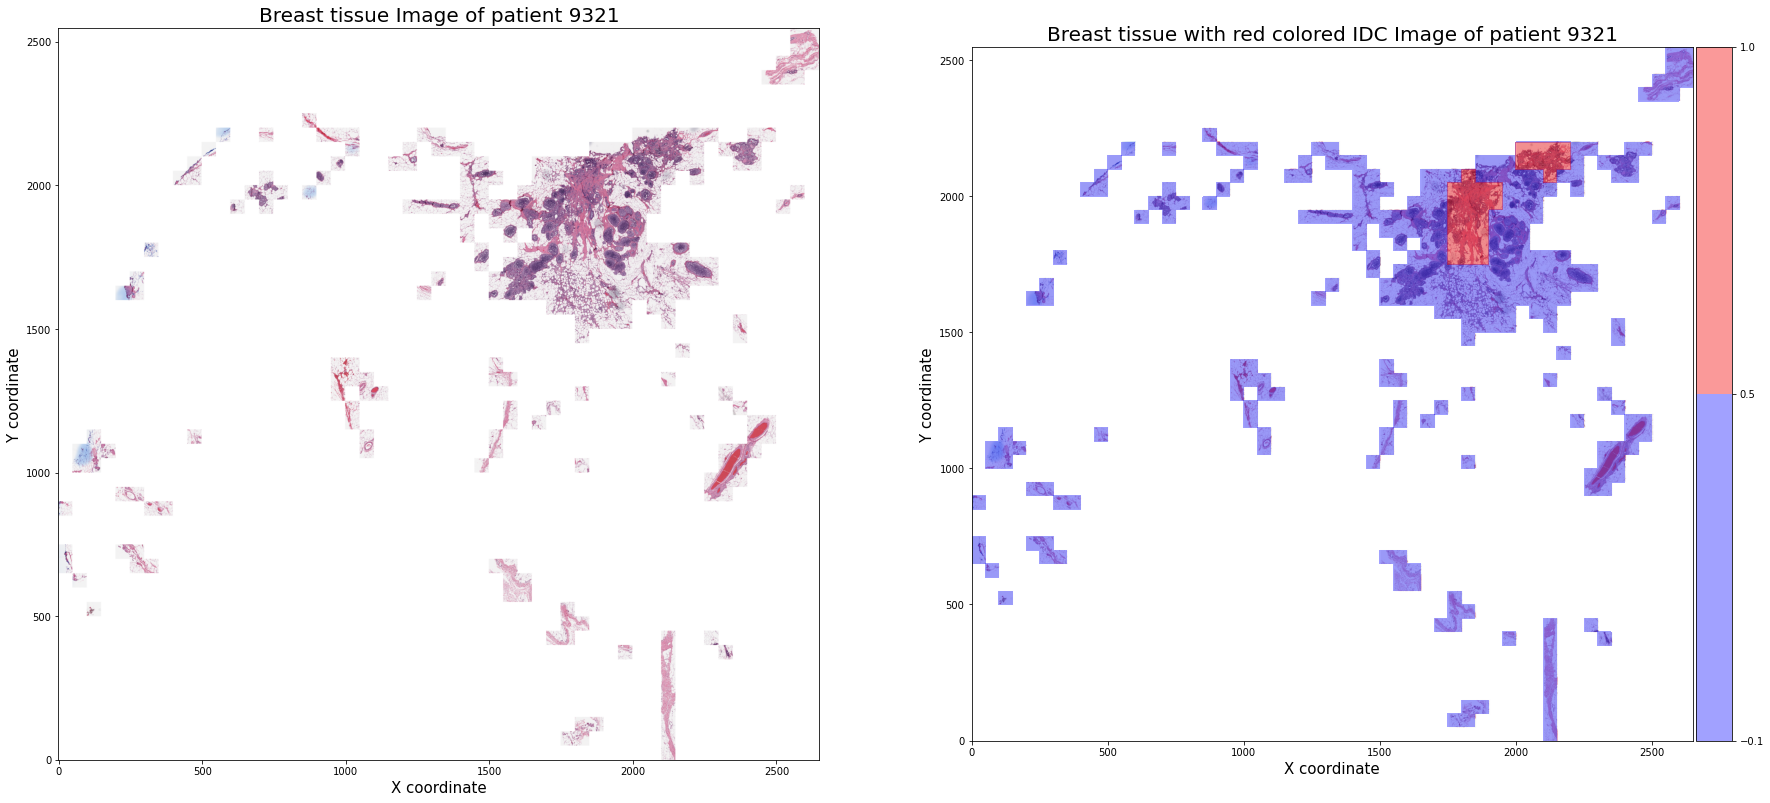

In [8]:
whole_slice_image(data)

The tissue in the red part corresponding to the IDC patch generally has a dark color.  
In this project, I aim to make predictions as similar to the picture on the right as possible by learning using deep learning.

# Prepare training and testing datasets and train deep learning model
Training & testing datasets for deep learning learning are first **separated based on patient id**.  
**(training : testing = 3 : 1)**  
The reason for separating based on the patient's id is to exclude a specific id from learning for the purpose of improving the performance of the model in the future because there is a possibility that the whole slide image of a specific patient is inappropriate for learning.  
(Examples of incompatibility: When it is difficult to distinguish between iDC and non-IDC because the degree of staining is too severe or weak, when it is judged that the tissue is abnormally shaped and negatively affects learning)  
Based on the separated patient's ID, the patch images are loaded and prepared by transforming them into an ndarray (numpy array) form.

## Getting the image dataset from image path
Receives image data of a fixed size (50 x 50) from the image source path.  
(Images other than 50 x 50 size are excluded because there is a high possibility that they are edges of the whole slide image or the wrong part)  
The obtained image data is converted to ndarray and returned.

In [9]:
def get_img_array(img_path, size):
    images = []
    for img in img_path:
        img = keras.preprocessing.image.load_img(img, target_size = size)
        img = keras.preprocessing.image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        images.append(img)
    images = np.vstack(images)
    return images

## Spliting training and testing patient ids
Separate patient ids for use in training and testing.
And it gets the image data from each patient ID.


In [10]:
def get_train_test_data(df, save = False):
    patient_ids = df['ID'].unique()
    train_ids, test_ids = train_test_split(patient_ids) # Split for training and testing by patient ID
    print('Train patient IDs: ', train_ids)
    print('Test patient IDs: ', test_ids)

    # Copy dataframe corresponding to each ID
    train_set = df[df['ID'].apply(lambda x: x in train_ids)]
    test_set = df[df['ID'].apply(lambda x: x in test_ids)]

    size = (50, 50)
    
    train_x = get_img_array(train_set['image_path'], size)
    test_x = get_img_array(test_set['image_path'], size)
    train_y = train_set['cancer']
    test_y = test_set['cancer']

    if save:
        np.save('./X_train.npy',train_x)
        np.save('./X_test.npy',test_x)
        np.save('./y_train.npy',train_y)
        np.save('./y_test.npy',test_y)
    
    return (train_ids, test_ids), (train_x, train_y), (test_x, test_y)

In [11]:
(train_ids, test_ids), (X_train, y_train), (X_test, y_test) = get_train_test_data(data)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

Train patient IDs:  [15513 12870  9267  9225 16551  9255 15516 13404 10276 15472 13401  9022
 14211 12749 15839 16534 16014 10302  9178 12875 14212 12880 12892 13691
 16531 16570 12811 14190]
Test patient IDs:  [13613 12872 12882 10253  9322  9321 12823 16552 10299 10269]
X_train shape:  (30810, 50, 50, 3)
y_train shape:  (30810,)
X_test shape:  (9402, 50, 50, 3)
y_test shape:  (9402,)


## Deep learning model training
The CNN part of **EfficientNetB2** is used and the **fully-connected network** part consists of **FC256-FC128-FC64**.

### Activation functions
- **'ReLU'** was used for the activation functions of the **remaining layers except for the last layer**.
- **The last layer used 'Sigmoid'** as an activation function for binary classification.

### Epochs
- **50**

### Loss function
- **Binary Corssentropy** is used as it must be classified as IDC or non-IDC

### Validation
- **20%** of the training dataset is used as validation

### Metrics
- **Loss, accuracy values**

### Optimizer
- Using **Adam** from Keras
- The **learning rate** is set to **0.001**

# Data source and references  
## Data source
- https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images

## Reference
**1)**  https://www.kaggle.com/code/allunia/breast-cancer  
**2)**  https://www.healthline.com/health/invasive-ductal-carcinoma-treatment#symptoms  
**3)**  Bouvier AS, Panchbhaya N, Brochard C, Marchand E, Mezzadri M, Leveau-Vallier AS, Cornelis F, Benifla JL, Mimoun C. Uterine metastasis from invasive ductal breast carcinoma: A case report with literature review. J Gynecol Obstet Hum Reprod. 2021 Jan;50(1):101993. doi: 10.1016/j.jogoh.2020.101993. Epub 2020 Nov 17. PMID: 33217599.  
**4)**  Janowczyk A, Madabhushi A. Deep learning for digital pathology image analysis: A comprehensive tutorial with selected use cases. J Pathol Inform. 2016 Jul 26;7:29. doi: 10.4103/2153-3539.186902. PMID: 27563488; PMCID: PMC4977982.  
**5)**  Cruz-Roa A, Gilmore H, Basavanhally A, Feldman M, Ganesan S, Shih N, et al. (2018) Highthroughput adaptive sampling for whole-slide histopathology image analysis (HASHI) via convolutional neural networks: Application to invasive breast cancer detection. PLoS ONE 13(5): e0196828. https://doi.org/10.1371/journal. pone.0196828  
**6)**  Angel Cruz-Roa, Ajay Basavanhally, Fabio González, Hannah Gilmore, Michael Feldman, Shridar Ganesan, Natalie Shih, John Tomaszewski, Anant Madabhushi, "Automatic detection of invasive ductal carcinoma in whole slide images with convolutional neural networks," Proc. SPIE 9041, Medical Imaging 2014: Digital Pathology, 904103 (20 March 2014); https://doi.org/10.1117/12.2043872  